## Text classification using Neural Networks

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model with learning embeddings
- Download pre-trained embeddings from Glove
- Use these pre-trained embeddings

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.
- The following projects can replicate similar word embedding models much more efficiently: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.


### 20 Newsgroups Dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups http://qwone.com/~jason/20Newsgroups/

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [2]:
sample_idx = 1000
print(newsgroups_train["data"][sample_idx])

From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)
Subject: Diamond SS24X, Win 3.1, Mouse cursor
Organization: National Library of Medicine
Lines: 10


Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email

--Don Lindbergh
dabl2@lhc.nlm.nih.gov



In [3]:
target_names = newsgroups_train["target_names"]

target_id = newsgroups_train["target"][sample_idx]
print("Class of previous message:", target_names[target_id])

Class of previous message: comp.os.ms-windows.misc


Here are all the possible classes:

In [4]:
target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [6]:
from tensorflow.contrib import keras
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000

# get the raw text data
texts_train = newsgroups_train["data"]
texts_test = newsgroups_test["data"]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 134142 unique tokens.


Tokenized sequences are converted to list of token ids (with an integer code):

In [7]:
sequences[0]

[14,
 4330,
 1352,
 15,
 11234,
 38,
 250,
 29,
 42,
 298,
 9,
 17,
 95,
 78,
 91,
 4330,
 1352,
 15,
 34,
 77,
 3,
 2967,
 610,
 1773,
 32,
 211,
 8,
 26,
 1308,
 27,
 171,
 66,
 47,
 123,
 10112,
 63,
 16,
 17,
 298,
 8,
 708,
 1,
 86,
 263,
 11,
 26,
 4,
 36,
 1500,
 2267,
 298,
 1163,
 2,
 18,
 14,
 1,
 1347,
 13695,
 845,
 16114,
 11,
 26,
 337,
 4,
 1,
 4049,
 80,
 182,
 484,
 7,
 1376,
 1,
 843,
 8321,
 26,
 1840,
 14,
 1,
 818,
 3,
 1,
 726,
 17,
 9,
 44,
 8,
 88,
 27,
 171,
 39,
 4,
 833,
 273,
 1080,
 2918,
 198,
 3,
 2809,
 153,
 17,
 298,
 9,
 239,
 629,
 25,
 808,
 357,
 13,
 21,
 16,
 17,
 386,
 298,
 181,
 112,
 188,
 206,
 1503,
 1343,
 2,
 13,
 35,
 58,
 7972]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [8]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 134142)

In [9]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [10]:
" ".join([index_to_word[i] for i in sequences[0]])

"from wam umd edu where's my thing subject what car is this nntp posting host wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can a model name engine specs years of production where this car is made history or whatever info you have on this looking car please e mail thanks il brought to you by your neighborhood"

Let's have a closer look at the tokenized sequences:

In [11]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 302.5
max length: 15365


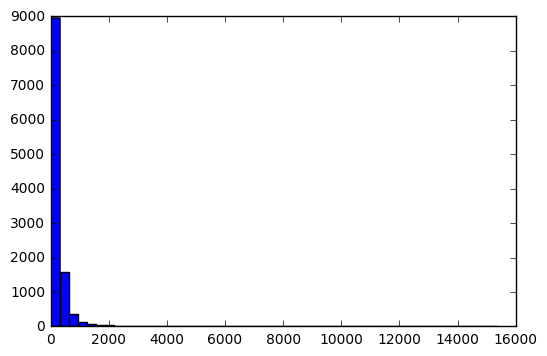

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 1000 symbols:

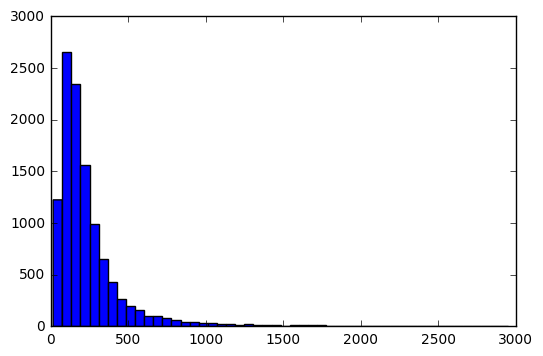

In [13]:
plt.hist([l for l in seq_lens if l < 3000], bins=50);

Let's truncate and pad all the sequences to 1000 symbols to build the training set:

In [14]:
from keras.preprocessing.sequence import pad_sequences


MAX_SEQUENCE_LENGTH = 1000

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (11314, 1000)
Shape of data test tensor: (7532, 1000)


In [15]:
from keras.utils.np_utils import to_categorical
y_train = newsgroups_train["target"]
y_test = newsgroups_test["target"]

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (11314, 20)


### A simple supervised CBOW model in Keras

The following computes a very simple model, as described in [fastText](https://github.com/facebookresearch/fastText):

<img src="images/fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 20 classes (+ softmax)

In [16]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [17]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=10, batch_size=128)

Train on 10182 samples, validate on 1132 samples
Epoch 1/10
10182/10182 [==============================] - 6s - loss: 2.9873 - acc: 0.0849 - val_loss: 2.9786 - val_acc: 0.1661
Epoch 2/10
10182/10182 [==============================] - 6s - loss: 2.9630 - acc: 0.1545 - val_loss: 2.9537 - val_acc: 0.1793
Epoch 3/10
10182/10182 [==============================] - 7s - loss: 2.9297 - acc: 0.1673 - val_loss: 2.9164 - val_acc: 0.1820
Epoch 4/10
10182/10182 [==============================] - 6s - loss: 2.8880 - acc: 0.2081 - val_loss: 2.8731 - val_acc: 0.2412
Epoch 5/10
10182/10182 [==============================] - 6s - loss: 2.8420 - acc: 0.2526 - val_loss: 2.8274 - val_acc: 0.2783
Epoch 6/10
10182/10182 [==============================] - 6s - loss: 2.7928 - acc: 0.3041 - val_loss: 2.7787 - val_acc: 0.3224
Epoch 7/10
10182/10182 [==============================] - 6s - loss: 2.7376 - acc: 0.3712 - val_loss: 2.7234 - val_acc: 0.3710
Epoch 8/10
10182/10182 [==============================] - 6s -

**Exercice**
 - compute model accuracy on test set

In [ ]:
# %load solutions/accuracy.py

### Building more complex models

**Exercise**
- From the previous template, build more complex models using:
  - 1d convolution and 1d maxpooling. Note that you will still need a GloabalAveragePooling or Flatten after the convolutions
  - Recurrent neural networks through LSTM (you will need to reduce sequence length before)
  
  
<img src="images/unrolled_rnn_one_output_2.svg" style="width: 600px;" />

**Bonus**
- You may try different architectures with:
  - more intermediate layers, combination of dense, conv, recurrent
  - different recurrent (GRU, RNN)
  - bidirectional LSTMs

Note: The goal is to build working models rather than getting better test accuracy. To achieve much better results, we'd need more computation time and data quantity. Build your model, and verify that they converge to OK results.

In [ ]:
from keras.layers import Embedding, Dense, Input, Flatten
from keras.layers import Conv1D, LSTM, GRU
from keras.layers import MaxPooling1D, GlobalAveragePooling1D 
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# TODO

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
# %load solutions/conv1d.py

In [ ]:
# %load solutions/lstm.py

In [ ]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=10, batch_size=128)

### Loading pre-trained embeddings

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

In [ ]:
embeddings_index = {}
embeddings_vectors = []
f = open('glove100K.100d.txt', 'rb')

word_idx = 0
for line in f:
    values = line.decode('utf-8').split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = word_idx
    embeddings_vectors.append(vector)
    word_idx = word_idx + 1
f.close()

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

In [ ]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)

In [ ]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

    
def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [ ]:
get_emb("computer")

### Finding most similar words

**Exercice**

Build a function to find most similar words, given a word as query:
- lookup the vector for the query word in the Glove index;
- compute the cosine similarity between a word embedding and all other words;
- display the top 10 most similar words.

**Bonus**

Change your function so that it takes multiple words as input (by averaging them)

In [ ]:
# %load solutions/most_similar.py

In [ ]:
most_similar("cpu")

In [ ]:
most_similar("pitt")

In [ ]:
most_similar("jolie")

Predict the future better than tarot:

In [ ]:
np.dot(get_normed_emb('aniston'), get_normed_emb('pitt'))

In [ ]:
np.dot(get_normed_emb('jolie'), get_normed_emb('pitt'))

In [ ]:
most_similar("1")

In [ ]:
# bonus: yangtze is a chinese river
most_similar(["river", "chinese"])

### Displaying vectors with  t-SNE


In [ ]:
from sklearn.manifold import TSNE

word_emb_tsne = TSNE(perplexity=30).fit_transform(glove_embeddings_normed[:1000])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)

for idx in range(1000):
    plt.annotate(inv_index[idx],
                 xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("tsne.png")
plt.show()

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with Glove embeddings:
 - take all words from our 20 Newgroup vocabulary (`MAX_NB_WORDS = 20000`), and look up their Glove embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix
- We may fix these embeddings or fine-tune them

In [ ]:
EMBEDDING_DIM = 100

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

Build a layer with pre-trained embeddings:

In [ ]:
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

### A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works suprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded.

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)

# We don't want to fine-tune embeddings
model.layers[1].trainable=False

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
model.fit(x_train, y_train, validation_split=0.1,
          nb_epoch=10, batch_size=128, )

# Note, on this type of task, this technique will 
# degrade results as we train much less parameters
# and we average a large number pre-trained embeddings.
# You will notice much less overfitting then!
# Using convolutions / LSTM will help
# It is also advisable to treat seperately pre-trained
# embeddings and words out of vocabulary.

### Reality check

On small/medium datasets, simpler classification methods usually perform better, and are much more efficient to compute. Here are two resources to go further:
- Naive Bayes approach, using scikit-learn http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
- Alec Radford (OpenAI) gave a very interesting presentation, showing that you need a VERY large dataset to have real gains from GRU/LSTM in text classification https://www.slideshare.net/odsc/alec-radfordodsc-presentation

However, when looking at features, one can see that classification using simple methods isn't very robust, and won't generalize well to slightly different domains (e.g. forum posts => emails)

Note: Implementation in Keras for text is very slow due to python overhead and lack of hashing techniques. The fastText implementation https://github.com/facebookresearch/fasttext is much, much faster.

## Going further

- Compare pre-trained embeddings vs specifically trained embeddings
- Train your own wordvectors in any language using [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
- Check [Keras Examples](https://github.com/fchollet/keras/tree/master/examples) on `imdb` sentiment analysis
- Install fastText (Linux or macOS only, use the Linux VM if under Windows) and give it a try on the classification example in its repository.